# Capstone: Airbnb Price Listing Prediction
## Part 4 Model Tuning

_Authors: Evonne Tham_

In the previous notebook, the XGBoost produced a high $R^2$ score of 0.967 and 0.749 for the train and validation sets respectively. Despite this, the model needs to be improve and fully leverage its advantages over other algorithms

This will be done by utilising gridsearch after which we will be able to look into the the features importance, a built-in function in XGBoost,. This model will be used as the production model in the next notebook as well.

## Contents of this notebook
- [1. Import Necessary Libraries and Load Data](#1.-Import-Necessary-Libraries-and-Load-Data)
- [2. Model Prep](#2.-Model-Prep)
- [3. GridSearch for Hyperparameter Tuning](#3.-GridSearch-for-Hyperparameter-Tuning)
    - [3.1. Defining Function for modelling](#3.1-Defining-Function-for-modelling)
    - [3.2. Fitting Models](#3.2.-Fitting-Models)
- [4. Model Evaluation](#3.-Model-Evaluation)
- [5. Re-training the Best Model (XGBoost)](#5.-Re-training-the-Best-Model-(XGBoost))
- [6. Feature Importances](#6.1.-Feature-Importances)
- [7.Evaluation of Final XGBoost Model on Test Set](#7.-Evaluation-of-Final-XGBoost-Model-on-Test-Set)
    - [7.1. Model Prep](#7.1.-Model-Prep)
    - [7.2. Model Evaluation](#7.2.-Model-Evaluation)

## 1. Import Necessary Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Saving models
import pickle

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load in Data 
train = pd.read_csv('../datasets/train.csv')

#Set id as index 
train.set_index('id', inplace=True)

print(f"Total Number of Listing: {train.shape[0]} | Total Number of Features: {train.shape[1]}")

Total Number of Listing: 10564 | Total Number of Features: 132


---
## 2. Model Prep

In [3]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns 
            if col != 'price' 
            and col != 'log_price' 
            and col != 'id' 
            and col != 'host_id']

X = train[features]
y = train['price']

# Validation Set 
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

---
## 3. GridSearch for Hyperparameter Tuning

### 3.1 Defining Function for modelling

Some of the important hyperparameters to tune an SVR are:
- C: Regularization parameter
- gamma: defines how much influence a single training example has
- Kernel: helps find a hyperplane in the higher dimensional space without increasing the computational cost.

Some of the important hyperparameters to tune an XGBoost are:

- gamma: Specifies the minimum loss reduction required to make a split.
- learning_rate: Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- max_depth: Determines how deeply each tree is allowed to grow during any boosting round.
- n_estimators:  Number of trees one wants to build.
- subsample: Ratio of the training instances which help in prevent overfitting.

In [4]:
def grid_modeller_val_scorer(classifier): 
    
    '''
    takes arguments "lr", "enet", "svr", "xgb"
    '''
    
    start = time.time()
    
    # Model instantiation
    clf_lr = LinearRegression()
    clf_enet = ElasticNetCV()
    clf_svr = SVR()
    clf_xgb = XGBRegressor()
    
    # Building the model pipelines incl. preprocessing where needed 
    # Setting up the parameter grids
    if classifier == "lr":
        pipe_lr = Pipeline([('rs', RobustScaler()),
                             ('clf_lr', clf_lr)])
        
        param_grid_lr = [{'clf_lr__fit_intercept': [True, False],
                          'clf_lr__normalize': [True, False]}]
        

        gs = GridSearchCV(pipe_lr, 
                          param_grid_lr, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1, 
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)
        
        
    elif classifier == "enet":
        pipe_enet = Pipeline([('rs', RobustScaler()), 
                             ('clf_enet', clf_enet)])
        
        param_grid_enet = [{'clf_enet__l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
                            'clf_enet__n_alphas': [1,10,100,1000,10000]}]
    
        gs = GridSearchCV(pipe_enet, 
                          param_grid_enet, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1, 
                          scoring = "r2") 
    
        gs.fit(X_train, y_train)
        
        
    elif classifier == "svr":
        pipe_svr = Pipeline([('rs', RobustScaler()),
                             ("clf_svr", clf_svr)])

        param_grid_svr = [{"clf_svr__C":[1,10], 
                          "clf_svr__gamma":[0.001, 0.01, 0.1, 1], 
                          "clf_svr__kernel":('linear', 'rbf')}]  
        
        gs = GridSearchCV(pipe_svr, 
                          param_grid_svr, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1,
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)   
        
    
    elif classifier == "xgb":
        pipe_xgb = Pipeline([('rs', RobustScaler()),
                            ("clf_xgb",clf_xgb)])
        
        param_grid_xgb  = [{
            'clf_xgb__gamma':[0, 0.3], 
            'clf_xgb__learning_rate': [0.05, 0.3], 
            'clf_xgb__max_depth':[2,3,5], 
            'clf_xgb__n_estimators': [1000], 
            'clf_xgb__subsample': [0.05, 0.3, 0.5]
        }]
                        
        gs = GridSearchCV(pipe_xgb, 
                          param_grid_xgb, 
                          cv=5, 
                          n_jobs=-1, 
                          verbose=1,
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)
        
    end = time.time()
        
    #get scores
    train_score = gs.score(X_train, y_train)
    val_score = gs.score(X_val, y_val)
    y_pred = gs.predict(X_val)
    
    #get R2, MSE Score, RMSE score
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = (mean_squared_error(y_val, y_pred))**0.5
    
    
    
    metrics_list= [train_score, val_score, gs.best_score_, r2, mse, rmse]
    
    # Print out total run time 
    print(f"Time taken to run: {round((end - start)/60,1)} minutes")
    print('==================================================================================')
    print('')

    # print out accuracy, estimator and parameters from GridSearchCV
    print(f'Best train accuracy score = {train_score}')
    print(f'Best validation accuracy score = {val_score}')
    print(f'Best grid search score = {gs.best_score_}')
    print(f'R2 score = {r2}')
    print(f'Mean Square Error = {mse}')
    print(f"Root mean squared error = {rmse}")
    print('==================================================================================')
    print('')
    
    print(f'Best estimator = {gs.best_estimator_}')
    print(f'Best parameters = {gs.best_params_}')
    print('==================================================================================')
    print('')
    
    print(f"metrics list for {classifier}:", metrics_list)
    
    return

### 3.2. Fitting Models

#### i. Linear Regression

In [5]:
grid_modeller_val_scorer("lr")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.6s finished


Time taken to run: 0.1 minutes

Best train accuracy score = 0.2650879092230466
Best validation accuracy score = 0.22068547609798173
Best grid search score = -3.546866311878883e+16
R2 score = 0.22068547609798173
Mean Square Error = 334578848.58170253
Root mean squared error = 18291.496619514284

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_lr',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=True))],
         verbose=False)
Best parameters = {'clf_lr__fit_intercept': False, 'clf_lr__normalize': True}

metrics list for lr: [0.2650879092230466, 0.22068547609798173, -3.546866311878883e+16, 0.22068547609798173, 334578848.58170253, 18291.496619514284]


#### ii. ElasticNetCV

In [6]:
grid_modeller_val_scorer("enet")

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed: 17.6min finished


Time taken to run: 18.2 minutes

Best train accuracy score = 0.2612188063746045
Best validation accuracy score = 0.22410695376376955
Best grid search score = 0.2483970578687794
R2 score = 0.22410695376376955
Mean Square Error = 333109924.26070374
Root mean squared error = 18251.29924856594

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_enet',
                 ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
                              fit_intercept=True, l1_ratio=1, max_iter=1000,
                              n_alphas=10000, n_jobs=None, normalize=False,
                              positive=False, precompute='auto',
                              random_state=None, selection='cyclic', tol=0.0001,
                              verbose=0))],
         verbose=False)
Best parameters = {'clf_enet__

#### iii. Support Vector Regressor

In [7]:
grid_modeller_val_scorer("svr")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 13.1min finished


Time taken to run: 13.3 minutes

Best train accuracy score = 0.05695912386046931
Best validation accuracy score = 0.04614044559045005
Best grid search score = 0.05151517371362776
R2 score = 0.04614044559045005
Mean Square Error = 409515313.310301
Root mean squared error = 20236.484707337415

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_svr',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma=0.001, kernel='linear', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Best parameters = {'clf_svr__C': 10, 'clf_svr__gamma': 0.001, 'clf_svr__kernel': 'linear'}

metrics list for svr: [0.05695912386046931, 0.04614044559045005, 0.05151517371362776, 0.04614044559045005, 409515313.310301, 20236.484707337415]


#### iv. Extreme Gradient Boosting Trees Regressor ("XGB") 

In [8]:
grid_modeller_val_scorer("xgb")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 27.8min finished


Time taken to run: 28.3 minutes

Best train accuracy score = 0.9620456204103222
Best validation accuracy score = 0.766377423060412
Best grid search score = 0.7677560654782276
R2 score = 0.766377423060412
Mean Square Error = 100299905.1060482
Root mean squared error = 10014.984029245788

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=nan, monotone_constraint

---
## 4. Model Evaluation
The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [9]:
metrics_list= ["train_score", "val_score", "gs.best_score_", "r2", "mse", "rmse"]

lr = [0.2650879092230466, 0.22068547609798173, 
      -3.546866311878883e+16, 0.22068547609798173, 
      334578848.58170253, 18291.496619514284]
    
enet = [0.2612188063746045, 0.22410695376376955, 
        0.2483970578687794, 0.22410695376376955, 
        333109924.26070374, 18251.29924856594]

svr = [0.05695912386046931, 0.04614044559045005, 
       0.05151517371362776, 0.04614044559045005, 
       409515313.310301, 20236.484707337415]

xgb = [0.9620456204103222, 0.766377423060412, 
       0.7677560654782276, 0.766377423060412, 
       100299905.1060482, 10014.984029245788]


eval_data = [lr, enet, svr, xgb]

column_names = metrics_list

index = ["Linear Regression", "ElasticNetCV", "Support Vector Regressor", "XGBoost"]

eval_df = pd.DataFrame(eval_data, columns=column_names, index=index)
    
eval_df = eval_df.round(decimals = 4)
eval_df

,train_score,val_score,gs.best_score_,r2,mse,rmse
Linear Regression,0.2651,0.2207,-3.546866e+16,0.2207,3.345788e+08,18291.4966
ElasticNetCV,0.2612,0.2241,2.484000e-01,0.2241,3.331099e+08,18251.2992
Support Vector Regressor,0.0570,0.0461,5.150000e-02,0.0461,4.095153e+08,20236.4847
XGBoost,0.9620,0.7664,7.678000e-01,0.7664,1.002999e+08,10014.9840


Based on this table and our particular output reproduced above, we can see that Support Vector Machine Regressor performed the worst as the train set and validation set has a $R^2$ less than 0.01. This handily beats the baseline model score of -0.00029, nevertheless.

Linear Regression and ElasticNet performed poorly as well, eventhough there's not much difference between the $R^2$ score on train set and the validation set. 

Hence the clear winner is eXtreme Gradient Boosting. It has the highest $R^2$ of 0.7884 on the entire validation set, which means that the model is able to account for almost 80% of the variance in the target variable. With a $RMSE$ score of 10015, what this means is that our model's prediction is on average off by 10015¥ in terms of predicting the property's price. This is pretty good for a preliminary model using regression techniques.

***The best parameters are:*** 
- gamma: 0, 
- learning_rate: 0.05, 
- max_depth: 5, 
- n_estimators: 1000, 
- subsample: 0.5

---
## 5. Price Vs Log Price Comparison

Let's see if our model is better at predicting price as it is or better when it is transformed.

### 5.1. Price

In [10]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns 
            if col != 'price' 
            and col != 'log_price' 
            and col != 'id' 
            and col != 'host_id']

X = train[features]
y = train['price']

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

# Scale 
rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_val_rs = rs.transform(X_val)

# Instantiate Best Model
xgb = XGBRegressor(gamma = 0,
                   learning_rate = 0.05, 
                   max_depth = 5, 
                   n_estimators = 1000, 
                   subsample = 0.5)

# Fit Model
xgb.fit(X_train_rs, y_train)

# Predict
y_pred_train = xgb.predict(X_train_rs)
y_pred_val = xgb.predict(X_val_rs)

# Model Evaluation
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
print(f"R2 Score on Training Set: {round(r2_train, 4)}")
print(f"R2 Score on Validation Set: {round(r2_val, 4)}")
print('===============================================')

mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"MSE Score on Training Set: {round(mse_train, 4)}")
print(f"MSE Score on Validation Set: {round(mse_val, 4)}")
print('===============================================')

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE Score on Training Set: {round(rmse_train, 4)}")
print(f"RMSE Score on Validation Set: {round(rmse_val, 4)}")

R2 Score on Training Set: 0.962
R2 Score on Validation Set: 0.7664
MSE Score on Training Set: 16584165.6602
MSE Score on Validation Set: 100299905.106
RMSE Score on Training Set: 4072.3661
RMSE Score on Validation Set: 10014.984


Once again, it has a $R^2$ of 0.7664 and a $RMSE$ score of 10014.98 on the validation set. hence we can proceed futher with the analysis

### 5.2. Log Price

In [11]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns 
            if col != 'price' 
            and col != 'log_price' 
            and col != 'id' 
            and col != 'host_id']

X = train[features]
y = train['price']

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

# Scale 
rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_val_rs = rs.transform(X_val)

# Instantiate Best Model
xgb = XGBRegressor(gamma = 0,
                   learning_rate = 0.05, 
                   max_depth = 5, 
                   n_estimators = 1000, 
                   subsample = 0.5)

# Fit Model
xgb.fit(X_train_rs, np.log(y_train))

# Predict
y_pred_train = np.exp(xgb.predict(X_train_rs))
y_pred_val = np.exp(xgb.predict(X_val_rs))

# Model Evaluation
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
print(f"R2 Score on Training Set: {round(r2_train, 4)}")
print(f"R2 Score on Validation Set: {round(r2_val, 4)}")
print('===============================================')

mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"MSE Score on Training Set: {round(mse_train, 4)}")
print(f"MSE Score on Validation Set: {round(mse_val, 4)}")
print('===============================================')

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE Score on Training Set: {round(rmse_train, 4)}")
print(f"RMSE Score on Validation Set: {round(rmse_val, 4)}")

R2 Score on Training Set: 0.916
R2 Score on Validation Set: 0.7134
MSE Score on Training Set: 36694095.4639
MSE Score on Validation Set: 123053540.9752
RMSE Score on Training Set: 6057.5651
RMSE Score on Validation Set: 11092.9501


As seen above, XGBoost model got a worse performance when the target variable is being transformed. This is because regression trees make splits in a way that minimizes the MSE, which means that they minimize the sum of the variances of the target in the children nodes. Hence, when variable is skewed, high values will affect the variances and push the split points towards higher values - forcing the decision tree to make less balanced splits and trying to "isolate" the tail from the rest of the points. 

--- 
## 6. Feature Importances

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

Credit: [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)

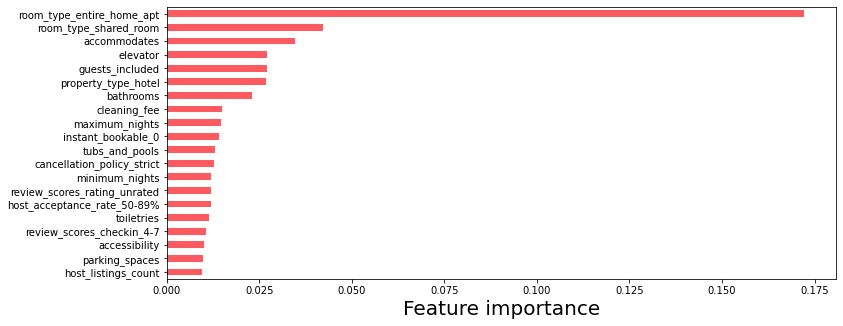

In [12]:
# Visualizing top features in our production model. 
key_features = pd.Series(xgb.feature_importances_, index = X.columns)
key_features.nlargest(20).sort_values().plot(kind='barh', color = '#FF5A5F', figsize = (12,5))
plt.xlabel("Feature importance", fontsize=20);

About a quiet a number of features have a very low feature importance or are of of 0 in this XGBoost regression model. And here are the top 10 most important features:
1. Room Type: Entire home/apt
2. Room Type: Shared room
3. Number of guests listing can Accommodate 
4. Whether there's Elevator
5. Property Type: Hotel
6. Number of Guests Included
7. Distance from city centers
8. The Maximum Night Stay 
9. Instant Bookable
10. Cleaning Fee

As expected the most important features being the room type which came out to be the entire flat. Listings are priced higher if the offer is for the entire flat/house. This could also suggest that offering the flat/house as a whole, rather than each bedroom individually, may be better overall, given the large difference in importance compared to the second most important feature, which is room type as well.

The third highest is how many people the property accommodates, which explains as that's one of the main things one would use to filter when searching for properties with in the first place.

However, it is surprising that location or distance features did not appear in the top ten list. 

## 7. Evaluation of Final XGBoost Model on Test Set

Now that we've selected the model with the best performance on the validation set and target variable, we're going to retrain the model on the combined train + validation sets using our best hyperparameter combination and see how well the model fair on the "unseen" data.

In [13]:
# Load in Data 
test = pd.read_csv('../datasets/test.csv')

# Set id as index 
test.set_index('id', inplace=True)

### 7.1. Model Prep

In [14]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns 
            if col != 'price' 
            and col != 'log_price' 
            and col != 'id' 
            and col != 'host_id']

X_train = train[features]
y_train  = train['price']
X_test = test[features]
y_test = test['price']

# Scale 
rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_test_rs = rs.transform(X_test)

# Instantiate Best Model
xgb = XGBRegressor(gamma = 0,
                   learning_rate = 0.05, 
                   max_depth = 5, 
                   n_estimators = 1000, 
                   subsample = 0.5)

# Model Fit
xgb.fit(X_train_rs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 7.2. Model Evaluation

In [15]:
# Predict
y_pred_test = xgb.predict(X_test_rs)

# Model Evaluation
r2_cross_val_score = np.mean(cross_val_score(xgb, X_train_rs, y_train, scoring="r2"))
train_score = xgb.score(X_train_rs, y_train)
test_score = xgb.score(X_test_rs, y_test)

r2 = r2_score(y_test, y_pred_test)
print(f"R2 Score on Test Set: {round(r2, 4)}")
print('===============================================')

mse = mean_squared_error(y_test, y_pred_test)
print(f"MSE Score on Test Set: {round(mse, 4)}")
print('===============================================')

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE Score on Test Set: {round(rmse, 4)}")
print('===============================================')

metrics_list= [train_score, test_score, r2_cross_val_score, r2, mse, rmse]
print(f"Metrics list for XGB on Test Set = {metrics_list}")

R2 Score on Test Set: 0.796
MSE Score on Test Set: 98592908.2122
RMSE Score on Test Set: 9929.3962
Metrics list for XGB on Test Set = [0.9511465965934983, 0.7959612172185586, 0.7737680129450859, 0.7959612172185586, 98592908.21221578, 9929.396165538757]


In [16]:
# building our final XGB Model metrics into a DataFrame
xgb_metrics_list= ["train_score", "val_score", "gs.best_score_", "r2", "mse", "rmse"]

xgb_final = [0.9511465965934983, 0.7959612172185586, 
             0.7737680129450859, 0.7959612172185586, 
             98592908.21221578, 9929.396165538757]

xgb_final_df = pd.DataFrame(xgb_final).T

xgb_final_df.columns = xgb_metrics_list

xgb_final_df.rename(index = {0:"XGBoost (Test Set)"}, inplace=True)

# Stack the DataFrames on top of each other
vertical_stack = pd.concat([eval_df, xgb_final_df], axis=0)

vertical_stack = vertical_stack.round(decimals = 4)

vertical_stack

,train_score,val_score,gs.best_score_,r2,mse,rmse
Linear Regression,0.2651,0.2207,-3.546866e+16,0.2207,3.345788e+08,18291.4966
ElasticNetCV,0.2612,0.2241,2.484000e-01,0.2241,3.331099e+08,18251.2992
Support Vector Regressor,0.0570,0.0461,5.150000e-02,0.0461,4.095153e+08,20236.4847
XGBoost,0.9620,0.7664,7.678000e-01,0.7664,1.002999e+08,10014.9840
XGBoost (Test Set),0.9511,0.7960,7.738000e-01,0.7960,9.859291e+07,9929.3962


Looking at all our metrics above in the combined table, after training our XGB model with its ideal parameters onto the entire train set, the $R^2$ rises to 0.8029 from the initial validation $R^2$ to 0.7659. $RMSE$ has also decreased from 10024.7122 to 9759.1505

The fact that $R^2$ score on the full recombined train set has a a higher score than the validation set $R^2$ score, as well as the lower RMSE Score, indicates that the model will generalize well on unseen data. Hence, we can now proceed to our production model.

<---- Go back to the previous notebook [Feature Engineering and Model Benchmarks](./03_Feature_Engineering_and_Model_Benchmarks.ipynb)

----> Proceed to the next notebook for [Production Model](./05_Production_Model.ipynb)